In [1]:
#!pip install optuna
import pandas as pd
import pickle
import datetime
import re
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import matplotlib.pyplot as pit
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive

# exports
def plot_calibration_curve(named_classifiers, X_test, y_test):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

def preprocessing(results, kako=5):
    df = results.copy()

    df.drop([
        'compi',
        'compi_num', 
        "speed", 
        'rank',
#         'result',
        'course',
        'born',
        '1走前走破タイム', '2走前走破タイム', '3走前走破タイム', '4走前走破タイム', '5走前走破タイム',
        '1走前補正タイム', '2走前補正タイム', '3走前補正タイム', '4走前補正タイム', '5走前補正タイム',
        '1走前結果', '2走前結果', '3走前結果', '4走前結果', '5走前結果',
        '1走前オッズ', '2走前オッズ', '3走前オッズ', '4走前オッズ', '5走前オッズ',
        'horse_race_id',  'body_weight','body_weight_in_de'
#         '季節出走回数', '季節勝率偏差値', '季節連対率偏差値', '季節複勝率偏差値',

    ], axis=1, inplace=True)
    df['date'] = df['date'].astype(str).map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    df = df.sort_values(by='date', ascending = False)
    df = df.set_index('race_id')
    return df

def split_data(df, test_size=0.3, place=None):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]

    train = df.loc[train_ids]
    test = df.loc[test_ids]
    
    return train, test

def train_valid_split_data(df, test_size=0.3):
    sorted_ids = df.sort_values('date').index.unique()
    train_ids = sorted_ids[:round(len(sorted_ids) * (1-test_size))]
    test_ids = sorted_ids[round(len(sorted_ids) * (1-test_size)):]
    
    train = df.loc[train_ids]
    valid = df.loc[test_ids]
    
    return train, valid

def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))
    # df2 = pd.get_dummies(df2, sparse=True)
    df2 = pd.get_dummies(df2)
    for column in target_columns:
        df2[column] = df2[column].astype('category')
        
    return df2

class TimeModel:
    def __init__(self, model, base_data):
        self.model = model
        self.base_data = base_data
        
    def pred_time(self, X):
        pred_time = self.base_data.copy()[['id', 'popular']]
        actual_table = X.copy()[['id', 'h_num', 'place_id']]

        X = X.drop(['id'], axis=1)
        actual_table['pred_time'] = model.predict(X)

        actual_table = actual_table.reset_index()
        pred_time = pred_time.reset_index()
        actual = pred_time.merge(actual_table, left_index=True, right_index=True, how='right')
        actual.drop(['id_x', 'id_y', 'race_id_y'], axis=1, inplace=True)

        return actual
    
    def race_pred_time(self, X):
        actual = self.pred_time(X)
        groups = actual.groupby('race_id_x').groups
        column_list = ["h_num", 'pred_time', 'popular']

        new_df = pd.DataFrame()
        max_length = 0
        for group, indexes in groups.items():
            # 最後に並び替えをさせるのに最大作成された項目数を記録
            length = len(indexes)+1
            if length > max_length:
                max_length = length

            columns = list()
            values = list()
            columns += ['race_id', 'place_id']
            values += [actual.iloc[indexes]['race_id_x'].T.tolist()[0], actual.iloc[indexes]['place_id'].T.tolist()[0]]

            for target_column in column_list:
                columns += [f'{target_column}_{x}' for x in range(1, length)]
                sort_values = actual.iloc[indexes, :].sort_values(by='pred_time', ascending = False)
                values += sort_values[target_column].T.tolist()

            record_df = pd.DataFrame([values], columns=columns)
            new_df = pd.concat([new_df, record_df], axis=0)

        return new_df

class ModelEvaluator:
    def __init__(self, model, haitou_table, std = True):
        self.model = model
        self.haitou = haitou_table
        self.std = std
        self.pp = None
        
    def predict_proba(self, X, std=True):
#         proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.pp is not None:
          return self.pp

        proba = pd.Series(self.model.predict_proba(X.drop(['id', 'odds', 'time_odds'], axis=1))[:, 1], index=X.index)
        if std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
            
        self.pp = proba
        return proba
    
    def prefict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def win_ratio(self, X):
        sum1 = pd.DataFrame(self.predict_proba(X).groupby(level=0).sum())
        y_pred = self.predict_proba(X)

        return [(p / sum1.loc[i])[0] for i, p in y_pred.items()]
    
    def score(self, y_true, X):
        proba = self.predict_proba(X, True)
        n = lambda x: 0.0 if np.isnan(x) else x
        proba = proba.map(n)
        return roc_auc_score(y_true, proba)
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({'features': X.columns, 'importance': self.model.feature_importances_})
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['h_num', 'odds', 'time_odds']]
        pred_table['pred'] = self.prefict(X, threshold)
        pred_table['win_ratio'] = self.win_ratio(X)
        if bet_only:
            pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'time_odds', 'win_ratio']]
#             pred_table = pred_table[pred_table['pred'] == 1][['h_num', 'odds', 'time_odds']]
            return pred_table
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        haitou = self.haitou.copy()
        df = haitou.merge(pred_table, left_index=True, right_index=True, how='right')

        n_hits = len(df[df['1着馬番'] == df['h_num']]) + len(df[df['2着馬番'] == df['h_num']]) + len(df[df['3着馬番'] == df['h_num']]) + len(df[df['4着馬番'] == df['h_num']])
        for i in range(1, 5):
            money += df[df[str(i) + '着馬番'] == df['h_num']]['複勝' + str(i)].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate,n_hits
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        df['単勝配当'] = df['単勝'].astype(int)
        
#         std = ((df['1着馬番'] ==  df['h_num']) * df['単勝配当'])\
#         .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['1着馬番'] == df['h_num']])
        
        money += df[df['1着馬番'] == df['h_num']]['単勝配当'].sum()
        return_rate =  (n_bets*100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        df = self.haitou.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1/pred_table['odds']).sum()
        std = ((df['1着馬番'] == df['h_num']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        df['h_num'] = df['h_num'].astype(float)
        df['馬番_1'] = df['1着馬番']
        n_hits = len(df.query('馬番_1 == h_num'))
        return_rate = n_hits/bet_money
        return n_bets, return_rate, n_hits
        
    
def gain(return_func, X, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        # 閾値を増やす        
        threshold = 1 * i /n_samples + min_threshold * (1 - i/n_samples)
        n_bets, return_rate, n_hits = return_func(X, threshold)
        if n_bets == 0:
            break;
        if n_bets > lower:
            gain[n_bets] = { 'return_rate': return_rate, 'n_hits': n_hits }
    return pd.DataFrame(gain).T

In [2]:
allrace = pd.read_pickle('./pickle_new/base_race_20220813_6.pickle')
time = pd.read_csv('./csv_new2/base/race_time.csv')
df = allrace.merge(time, how='left', on='id')

# df = allrace.query('course == 2')
all_r = preprocessing(df)
# grouped = all_r.groupby('race_id')
# all_r['correct_time'] = grouped['correct_time'].transform(lambda x: (x - x.mean()) / x.std())
all_r.drop(['気温', '1走前着差', '2走前着差','3走前着差',
#             '1走前スピードZI', '2走前スピードZI', '3走前スピードZI'
], axis=1, inplace=True)

for i in range(1, 63):
    all_r.drop(['peds' + str(i)], axis=1, inplace=True)

In [3]:
categorical = process_categorical(all_r, [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

train, valid = split_data(categorical)

In [4]:
target = pd.read_pickle('./pickle_new/new_race_20220903.pickle')
time = pd.read_csv('./csv_new2/base/race_time.csv')
target = target.merge(time, how='left', on='id')
target = target[target['date'].notnull()]
all_target = preprocessing(target)
# grouped_target = all_target.groupby('race_id')
# all_target['time'] = grouped_target['time'].transform(lambda x: (x - x.mean()) / x.std())

for i in range(1, 63):
    all_target.drop(['peds' + str(i)], axis=1, inplace=True)

test = process_categorical(all_target, [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

In [5]:
import optuna.integration.lightgbm as lgb_o

X_train = train.drop(['id', 'horse_id', 'date','correct_time', 'result', 'odds', 'popular',  'producer', 'owner'], axis=1)
# X_train = train.drop(['date'], axis=1)
y_train = train['correct_time']
X_valid = valid.drop(['date', 'horse_id', 'correct_time', 'result', 'odds', 'popular',  'producer', 'owner'], axis=1)
y_valid = valid['correct_time']
X_test = test.drop(['date', 'horse_id', 'correct_time', 'result', 'odds', 'popular',  'producer', 'owner'], axis=1)
y_test = test['correct_time']

In [6]:
import lightgbm as lgb
import optuna.integration.lightgbm as lgb_o

params = {
#   'task': 'train',
#   'boosting_type': 'gbdt',
  'objective': 'regression',
  'metric': 'rmse', 
#   'learning_rate': 0.1,
}

# model = lgb.LGBMRegressor()
# model.fit(
#     X_train, 
#     y_train,
#     eval_set=[(X_test.drop(['id'], axis=1), y_test), (X_train, y_train)],
#     verbose=-1
# )

# lgb.plot_metric(model)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid.drop(['id'], axis=1), y_valid, reference=lgb_train)
# lgb_test = lgb.Dataset(X_test.drop(['id'], axis=1), y_test, reference=lgb_train)

lgb_results = {} 

params = {'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.7428030658502613e-06,
 'lambda_l2': 9.047629861481605,
 'num_leaves': 217,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 100,
 'early_stopping_round': 50,
 'categorical_column': [2, 4, 5, 6, 7, 232, 236, 237, 309, 310, 312, 313]}

model = lgb.train(
  params=params,
  train_set=lgb_train,
  valid_sets=[lgb_train, lgb_valid],
#   valid_sets=[lgb_train, lgb_test],
  valid_names=['Train', 'Test'],
  num_boost_round=100,
) 

# model = lgb_o.train(
#     params,
#     lgb_train,
#     valid_sets=lgb_valid,
#     verbose_eval=False,
#     show_progress_bar=False,
#     num_boost_round=100,
#     early_stopping_rounds=50
# )

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59596
[LightGBM] [Info] Number of data points in the train set: 476633, number of used features: 531


/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 88.239849
[1]	Train's rmse: 11.6069	Test's rmse: 12.2275
Training until validation scores don't improve for 50 rounds
[2]	Train's rmse: 11.3531	Test's rmse: 11.9943
[3]	Train's rmse: 11.1253	Test's rmse: 11.793
[4]	Train's rmse: 10.95	Test's rmse: 11.6284
[5]	Train's rmse: 10.7982	Test's rmse: 11.4965
[6]	Train's rmse: 10.6397	Test's rmse: 11.3596
[7]	Train's rmse: 10.4962	Test's rmse: 11.2458
[8]	Train's rmse: 10.3918	Test's rmse: 11.1637
[9]	Train's rmse: 10.2955	Test's rmse: 11.0835
[10]	Train's rmse: 10.2098	Test's rmse: 11.0101
[11]	Train's rmse: 10.1266	Test's rmse: 10.9525
[12]	Train's rmse: 10.0463	Test's rmse: 10.9008
[13]	Train's rmse: 9.98424	Test's rmse: 10.8551
[14]	Train's rmse: 9.92412	Test's rmse: 10.8207
[15]	Train's rmse: 9.87382	Test's rmse: 10.7857
[16]	Train's rmse: 9.81597	Test's rmse: 10.7446
[17]	Train's rmse: 9.76077	Test's rmse: 10.7047
[18]	Train's rmse: 9.71685	Test's rmse: 10.6772
[19]	Train's rmse: 9.66235	Test's

In [3010]:
model.params

{'objective': 'regression',
 'metric': 'rmse',
 'feature_pre_filter': False,
 'lambda_l1': 1.7428030658502613e-06,
 'lambda_l2': 9.047629861481605,
 'num_leaves': 217,
 'feature_fraction': 0.41600000000000004,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100,
 'num_iterations': 100,
 'early_stopping_round': 50,
 'categorical_column': [2, 4, 5, 6, 7, 232, 236, 237, 309, 310, 312, 313]}

In [7]:
from sklearn.metrics import r2_score

X = X_valid.drop(['id'], axis=1)
y_pred = model.predict(X)
# r2_score(y_valid, y_pred)
y_pred

array([79.60370589, 64.93039055, 92.37040751, ..., 96.96132748,
       96.18697534, 87.58882222])

In [8]:
importances = pd.DataFrame({'features': X.columns, 'importance':model.feature_importance()})
importances.sort_values('importance', ascending=False)[:40]

,features,importance
5,trainer_id,3527
384,stallion_id,3283
2,jockey_id,2950
1,distance,418
44,1走前スピード指数,251
467,grade,241
13,間隔,207
501,上がり3F平均,191
43,1走前上がり指数,187
34,1走前上がり3F順,180


In [5]:
allrace = pd.read_pickle('./pickle_new/base_race_20220813_6.pickle')
time_odds_base = pd.read_csv('./csv_new2/time_odds.csv')
allrace = allrace.merge(time_odds_base, how='left', on='id')

df = allrace.query('course == 2')
all_r = preprocessing(df)
# all_r = preprocessing(allrace)
all_r['result'] = all_r['result'].map(lambda x: 1 if x == 1 else 0)

all_r.drop([
  '気温', '風向', '風速', '1走前着差', '2走前着差', '3走前着差', '4走前着差', '5走前着差',
#   '1走前スピードZI','2走前スピードZI', '3走前スピードZI', '4走前スピードZI', '5走前スピードZI',
], axis=1, inplace=True)
for i in range(1, 63):
    all_r.drop(['peds' + str(i)], axis=1, inplace=True)

categorical = process_categorical(all_r, [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'age', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

train1, valid1 = split_data(categorical)
valid1, test2 = train_valid_split_data(valid1)

target = pd.read_pickle('./pickle_new/new_race_20220904.pickle')
time_odds = pd.read_csv('./csv_new2/20220904/time_odds.csv')
target = target.merge(time_odds, how='left', on='id')
target = target[target['date'].notnull()]

target = target.query('course == 2')
target = preprocessing(target)
target['result'] = target['result'].map(lambda x: 1 if x == 1 else 0)
target.drop([
  '気温', '風向', '風速', '1走前着差', '2走前着差', '3走前着差', '4走前着差', '5走前着差',
#   '1走前スピードZI','2走前スピードZI', '3走前スピードZI', '4走前スピードZI', '5走前スピードZI',
  '先行指数', 'ペース指数', '上がり指数', 'スピード指数'
], axis=1, inplace=True)
for i in range(1, 63):
    target.drop(['peds' + str(i)], axis=1, inplace=True)
test1 = process_categorical(target,  [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'age', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

X_train1 = train1.drop(['id', 'date', 'result',  'time_popular', 'time_odds', 'odds', 'popular', 'horse_id'], axis=1)
y_train1 = train1['result']
X_valid1 = valid1.drop(['date', 'result', 'popular',  'time_popular', 'horse_id'], axis=1)
y_valid1 = valid1['result']
X_test1 = test1.drop(['date', 'result', 'popular',  'time_popular', 'horse_id'], axis=1)
y_test1 = test1['result']

In [81]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train1.values, y_train1.values)
lgb_valid = lgb_o.Dataset(X_valid1.values, y_valid1.values)

params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-09-03 20:45:31,708] A new study created in memory with name: no-name-4e6f673b-ef60-41ad-b0a4-2a96d27bfaae
feature_fraction, val_score: inf:   0%|                                                                        | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248693:  14%|########4                                                  | 1/7 [00:10<01:04, 10.79s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.214613	valid_1's binary_logloss: 0.248693
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248693:  29%|################8                                          | 2/7 [00:22<00:56, 11.36s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.21594	valid_1's binary_logloss: 0.250003
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248693:  43%|#########################2                                 | 3/7 [00:32<00:41, 10.49s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.221231	valid_1's binary_logloss: 0.248785
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248693:  57%|#################################7                         | 4/7 [00:42<00:31, 10.63s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.219765	valid_1's binary_logloss: 0.251068
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248153:  71%|##########################################1                | 5/7 [00:54<00:21, 10.85s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.215566	valid_1's binary_logloss: 0.248153
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248153:  86%|##################################################5        | 6/7 [01:07<00:11, 11.61s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.211666	valid_1's binary_logloss: 0.249845
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.248153: 100%|###########################################################| 7/7 [01:18<00:00, 11.16s/it]


Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.218222	valid_1's binary_logloss: 0.250284


num_leaves, val_score: 0.248153:   0%|                                                                        | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:   5%|###2                                                            | 1/20 [00:10<03:09, 10.00s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.220654	valid_1's binary_logloss: 0.249384
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.505526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  10%|######4                                                         | 2/20 [00:20<03:03, 10.18s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.222375	valid_1's binary_logloss: 0.24981
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  15%|#########6                                                      | 3/20 [00:30<02:49,  9.99s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.232146	valid_1's binary_logloss: 0.251905
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.461611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  20%|############8                                                   | 4/20 [00:40<02:40, 10.03s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.221354	valid_1's binary_logloss: 0.249931
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  25%|################                                                | 5/20 [00:50<02:29,  9.97s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.232023	valid_1's binary_logloss: 0.251645
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.487295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  30%|###################2                                            | 6/20 [00:59<02:17,  9.81s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.234758	valid_1's binary_logloss: 0.252595
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  35%|######################4                                         | 7/20 [01:09<02:08,  9.87s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.230016	valid_1's binary_logloss: 0.251567
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  40%|#########################6                                      | 8/20 [01:22<02:09, 10.80s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.193878	valid_1's binary_logloss: 0.249495
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  45%|############################8                                   | 9/20 [01:31<01:54, 10.43s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.232918	valid_1's binary_logloss: 0.251951
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.475763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  50%|###############################5                               | 10/20 [01:42<01:43, 10.34s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.230991	valid_1's binary_logloss: 0.252119
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.453406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  55%|##################################6                            | 11/20 [01:51<01:31, 10.13s/it]

Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.222238	valid_1's binary_logloss: 0.251822
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.474659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  60%|#####################################8                         | 12/20 [02:01<01:19,  9.99s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.234447	valid_1's binary_logloss: 0.252784
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  65%|########################################9                      | 13/20 [02:10<01:08,  9.74s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.235862	valid_1's binary_logloss: 0.251905
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.484081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  70%|############################################                   | 14/20 [02:22<01:01, 10.27s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.216038	valid_1's binary_logloss: 0.248684
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.510860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  75%|###############################################2               | 15/20 [02:32<00:51, 10.37s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.218781	valid_1's binary_logloss: 0.249023
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  80%|##################################################4            | 16/20 [02:40<00:38,  9.66s/it]

Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.242819	valid_1's binary_logloss: 0.254804
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.470243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.248153:  85%|#####################################################5         | 17/20 [02:51<00:30, 10.02s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217102	valid_1's binary_logloss: 0.24859
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.247777:  90%|########################################################7      | 18/20 [03:03<00:20, 10.47s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.214411	valid_1's binary_logloss: 0.247777
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.479376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.247777:  95%|###########################################################8   | 19/20 [03:13<00:10, 10.59s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217102	valid_1's binary_logloss: 0.24859
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.247777: 100%|###############################################################| 20/20 [03:23<00:00, 10.18s/it]


Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.235507	valid_1's binary_logloss: 0.251972


bagging, val_score: 0.247777:   0%|                                                                           | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247777:  10%|######7                                                            | 1/10 [00:12<01:50, 12.23s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.211307	valid_1's binary_logloss: 0.248355
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247777:  20%|#############4                                                     | 2/10 [00:20<01:20, 10.12s/it]

Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.232626	valid_1's binary_logloss: 0.252861
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247777:  30%|####################                                               | 3/10 [00:31<01:12, 10.36s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.215774	valid_1's binary_logloss: 0.247882
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.110760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  40%|##########################8                                        | 4/10 [00:42<01:03, 10.57s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  50%|#################################5                                 | 5/10 [00:50<00:49,  9.81s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.228218	valid_1's binary_logloss: 0.252806
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  60%|########################################1                          | 6/10 [01:00<00:38,  9.71s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.227786	valid_1's binary_logloss: 0.251158
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  70%|##############################################9                    | 7/10 [01:10<00:29,  9.69s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.223155	valid_1's binary_logloss: 0.252376
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.498782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  80%|#####################################################6             | 8/10 [01:19<00:18,  9.45s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.220375	valid_1's binary_logloss: 0.253209
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188:  90%|############################################################3      | 9/10 [01:29<00:09,  9.68s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.216422	valid_1's binary_logloss: 0.250108
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.474836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.247188: 100%|##################################################################| 10/10 [01:38<00:00,  9.84s/it]


Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.229826	valid_1's binary_logloss: 0.253291


feature_fraction_stage2, val_score: 0.247188:   0%|                                                            | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.479321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188:  17%|########6                                           | 1/6 [00:09<00:49,  9.90s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.220885	valid_1's binary_logloss: 0.250572
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188:  33%|#################3                                  | 2/6 [00:20<00:40, 10.00s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.218657	valid_1's binary_logloss: 0.251212
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188:  50%|##########################                          | 3/6 [00:29<00:28,  9.56s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.222285	valid_1's binary_logloss: 0.250752
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188:  67%|##################################6                 | 4/6 [00:39<00:19,  9.94s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.215934	valid_1's binary_logloss: 0.248726
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188:  83%|###########################################3        | 5/6 [00:48<00:09,  9.69s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.219942	valid_1's binary_logloss: 0.249319
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.247188: 100%|####################################################| 6/6 [00:58<00:00,  9.79s/it]


Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.216706	valid_1's binary_logloss: 0.249309


regularization_factors, val_score: 0.247188:   0%|                                                            | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.449539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:   5%|##6                                                 | 1/20 [00:10<03:27, 10.94s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.523705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  10%|#####2                                              | 2/20 [00:24<03:44, 12.49s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  15%|#######8                                            | 3/20 [00:35<03:21, 11.83s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.215978	valid_1's binary_logloss: 0.248763
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  20%|##########4                                         | 4/20 [00:48<03:18, 12.39s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  25%|#############                                       | 5/20 [00:59<02:58, 11.90s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.221024	valid_1's binary_logloss: 0.249142
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  30%|###############6                                    | 6/20 [01:11<02:43, 11.66s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211974	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  35%|##################2                                 | 7/20 [01:22<02:31, 11.64s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.209788	valid_1's binary_logloss: 0.247409
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  40%|####################8                               | 8/20 [01:33<02:17, 11.44s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  45%|#######################4                            | 9/20 [01:48<02:19, 12.64s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.203634	valid_1's binary_logloss: 0.248506
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  50%|#########################5                         | 10/20 [01:58<01:57, 11.71s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.2234	valid_1's binary_logloss: 0.250017
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.471220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  55%|############################                       | 11/20 [02:09<01:43, 11.47s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211975	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  60%|##############################6                    | 12/20 [02:20<01:30, 11.35s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.489150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  65%|#################################1                 | 13/20 [02:31<01:18, 11.28s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  70%|###################################6               | 14/20 [02:42<01:07, 11.21s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.483456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  75%|######################################2            | 15/20 [02:53<00:55, 11.17s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211972	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.486655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  80%|########################################8          | 16/20 [03:05<00:44, 11.18s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  85%|###########################################3       | 17/20 [03:16<00:33, 11.19s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  90%|#############################################9     | 18/20 [03:27<00:22, 11.15s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.490209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188:  95%|################################################4  | 19/20 [03:38<00:11, 11.14s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211971	valid_1's binary_logloss: 0.247188
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.247188: 100%|###################################################| 20/20 [03:49<00:00, 11.47s/it]


Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.211973	valid_1's binary_logloss: 0.247188


min_data_in_leaf, val_score: 0.247188:   0%|                                                                   | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.115032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.247188:  20%|###########8                                               | 1/5 [00:09<00:38,  9.66s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.220834	valid_1's binary_logloss: 0.249638
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.246540:  40%|#######################6                                   | 2/5 [00:21<00:33, 11.05s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.208945	valid_1's binary_logloss: 0.24654
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.246540:  60%|###################################4                       | 3/5 [00:32<00:22, 11.12s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.211388	valid_1's binary_logloss: 0.248771
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.468214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.246540:  80%|###############################################2           | 4/5 [00:43<00:10, 10.71s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.217224	valid_1's binary_logloss: 0.249543
[LightGBM] [Info] Number of positive: 16700, number of negative: 222323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57759
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 522
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069868 -> initscore=-2.588723
[LightGBM] [Info] Start training from score -2.588723
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.246425: 100%|###########################################################| 5/5 [00:54<00:00, 10.82s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.212104	valid_1's binary_logloss: 0.246425


In [82]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 39,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.695505240014514,
 'bagging_freq': 7,
 'min_child_samples': 25,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [6]:
import lightgbm as lgb

params = {
 'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 39,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.695505240014514,
 'bagging_freq': 7,
 'min_child_samples': 25,
 'num_iterations': 1000,
}

lgb_clf1 = lgb.LGBMClassifier(**params)
lgb_clf1.fit(X_train1.values, y_train1.values)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.695505240014514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.695505240014514
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0


LGBMClassifier(bagging_fraction=0.695505240014514, bagging_freq=7,
               feature_fraction=0.6, feature_pre_filter=False, lambda_l1=0.0,
               lambda_l2=0.0, min_child_samples=25, num_iterations=1000,
               num_leaves=39, objective='binary', random_state=100)

LGBM:
	AUC  : 0.773
	Brier: 0.062

CalibratedLGBM:
	AUC  : 0.755
	Brier: 0.074



/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/1644490106.py:58: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/1644490106.py:58: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/1644490106.py:58: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/1644490106.py:58: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/1644490106.py:58: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_1289

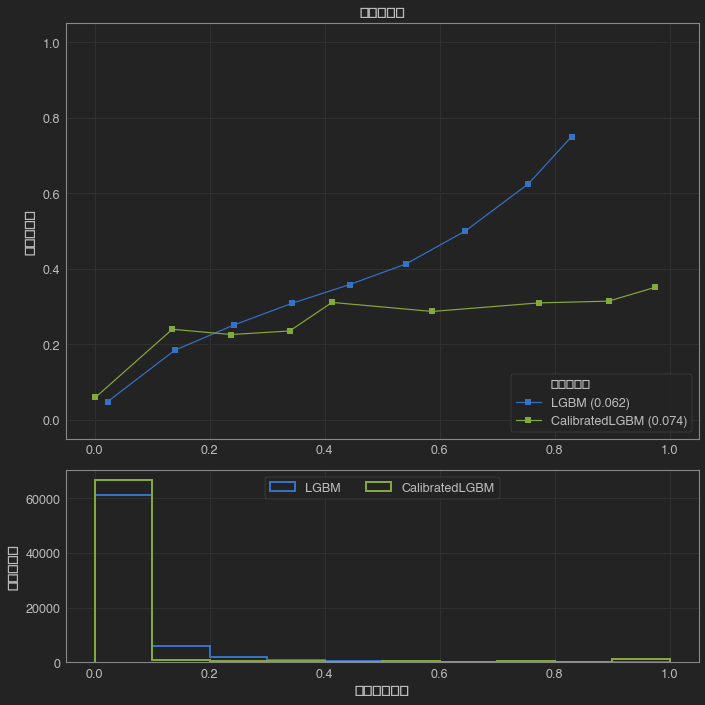

In [80]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

X_test2 = X_valid1.drop(['id', 'odds', 'time_odds'], axis=1)

calib = CalibratedClassifierCV(lgb_clf1, cv="prefit", method="isotonic")
calib.fit(X_train1.values, y_train1.values)
plot_calibration_curve(dict(LGBM=lgb_clf1, CalibratedLGBM=calib), X_test2, y_valid1)

In [4]:
haitou = pd.read_csv('./csv_new2/race_detail.csv')
haitou = haitou.set_index('race_id')

In [20]:
# # f = gain(me.fukusho_return, X_test)
# # tp = gain(me_valid.tansho_return_proper, X_valid1)
# t = gain(me_valid.tansho_return, X_valid1)

# # plt.plot(tp.index, tp['return_rate'], label='proper')
# # plt.plot(t.index, t['return_rate'], label='tansho')
# # plt.plot(f.index, f['return_rate'], label='fukusho')
# plt.figure(figsize=(10, 8))
# t['return_rate'].rename('tansho').plot(legend=True)
# # tp['return_rate'].rename('tansho_proper').plot(legend=True)
# # f['return_rate'].rename('fukusho').plot(legend=True)
# plt.grid()

In [70]:
tm_valid = TimeModel(model, valid)
new_df = tm_valid.race_pred_time(X_valid)

In [7]:
me_valid = ModelEvaluator(lgb_clf1, haitou, std=True)
me_valid.score(y_valid1, X_valid1)

NameError: name 'haitou' is not defined

In [ ]:
from jupyterthemes import jtplot

y_pred = me_valid.predict_proba(X_valid1).values

jtplot.style(theme='monokai')

fpr, tpr, thresholds = roc_curve(y_valid1, y_pred)
pit.plot(fpr, tpr, marker='o')
pit.xlabel("False positive rate")
pit.ylabel("True positive rate")
pit.grid()
pit.show()

In [ ]:
me_valid.feature_importance(X_train1, 40)

In [96]:
wr = me_valid.pred_table(X_valid1, 0.65)
wr['expected'] = wr['win_ratio'] * wr['time_odds'] 
# wr['expected_2'] = wr['time_odds']  / (1.05 / wr['win_ratio'])

In [137]:
race_grade = pd.read_csv('./csv_new2/races.csv')
race_grade = race_grade.set_index('race_id')
race_grade[['grade']]

bets = wr.merge(race_grade, on='race_id')

weather = pd.read_csv('./csv_new2/weathers.csv')
bets = bets.merge(weather[['race_id', 'place_id']], on='race_id')

# 賭ける馬
bt = bets[
#     ((bets['grade'] >= 2))
#     & 
     (bets['expected'] >= 1)
]
# bt = bets

bt

,race_id,h_num,odds,time_odds,win_ratio,expected,grade,place_id
3,2018041506030807,11,8.9,10.0,0.151353,1.513531,3,6
8,2018041509020807,9,12.8,12.4,0.133162,1.651205,3,9
13,2018041503010409,2,6.7,6.8,0.214619,1.459412,3,3
15,2018041503010403,9,6.3,7.5,0.204336,1.532523,2,3
16,2018041503010408,15,6.3,8.5,0.140821,1.196977,3,3
...,...,...,...,...,...,...,...,...
5704,2021041804010403,8,11.8,13.3,0.200115,2.661534,2,4
5712,2021042405020107,15,10.9,10.5,0.140671,1.477045,3,5
5714,2021042405020111,13,29.8,27.8,0.162651,4.521706,7,5
5720,2021042409020912,4,6.1,7.4,0.164153,1.214729,4,9


In [124]:
# 対象レース数
race_count = len(
    X_valid1
    .groupby('race_id')
)

# 対象レースの出現頻度
target_race_count = len(bets[(
     (bets['expected'] >= 1)
)].groupby('race_id'))

target_race_count / race_count

0.27334127930075486

In [99]:
# 賭ける馬の出現頻度
len(bt) / len(bets[(
 (bets['expected'] >= 1)
)])

1.0

In [138]:
bh = bt.merge(haitou, on='race_id')
bh[bh['h_num'] == bh['1着馬番']]['単勝'].max(), (bh[bh['h_num'] == bh['1着馬番']]['単勝'].sum() / (len(bt) * 100)) * 100, len(bh[bh['h_num'] == bh['1着馬番']]) / (len(bt)), len(bh[bh['h_num'] == bh['1着馬番']])

(8070, 106.16033755274262, 0.11392405063291139, 162)

In [143]:
h = fm.merge(haitou, on='race_id')

money = 0
f_c = 0
for i in range(1, 5):
    s = str(i)
    f_c += len(h[h['h_num'] == h[s + '着馬番']]['複勝' + s])
    money += h[h['h_num'] == h[s + '着馬番']]['複勝' + s].sum()

(len(bets) * 100), money, (money / (len(fm) * 100)) * 100, f_c / len(fm), f_c

(572900, 1161750.0, 84.50934749399869, 0.5279697388521132, 7258)

In [183]:
## 複勝
fukusho_allrace = pd.read_pickle('./pickle_new/base_race_20220813_6.pickle')
fukusho_time_odds_base = pd.read_csv('./csv_new2/time_odds.csv')
fukusho_allrace = fukusho_allrace.merge(fukusho_time_odds_base, how='left', on='id')

fukusho_df = fukusho_allrace.query('course == 2')
fukusho_all_r = preprocessing(fukusho_df)
fukusho_all_r['result'] = fukusho_all_r['result'].map(lambda x: 1 if x < 4 else 0)

fukusho_all_r.drop([
  '気温', '風向', '風速', '1走前着差', '2走前着差', '3走前着差', '4走前着差', '5走前着差',
#   '1走前スピードZI','2走前スピードZI', '3走前スピードZI', '4走前スピードZI', '5走前スピードZI',
], axis=1, inplace=True)
for i in range(1, 63):
    fukusho_all_r.drop(['peds' + str(i)], axis=1, inplace=True)

fukusho_categorical = process_categorical(fukusho_all_r, [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'age', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

fukusho_train1, fukusho_valid1 = split_data(fukusho_categorical)
valid1, test2 = train_valid_split_data(valid1)

f_target = pd.read_pickle('./pickle_new/new_race_20220904.pickle')
time_odds = pd.read_csv('./csv_new2/20220904/time_odds.csv')
f_target = f_target.merge(time_odds, how='left', on='id')

f_target = f_target.query('course == 2')
f_target = preprocessing(f_target)
f_target['result'] = f_target['result'].map(lambda x: 1 if x < 4 else 0)

f_target.drop([
  '気温', '風向', '風速', '1走前着差', '2走前着差', '3走前着差', '4走前着差', '5走前着差',
#   '1走前スピードZI','2走前スピードZI', '3走前スピードZI', '4走前スピードZI', '5走前スピードZI',
  '先行指数', 'ペース指数', '上がり指数', 'スピード指数'
], axis=1, inplace=True)
for i in range(1, 63):
    f_target.drop(['peds' + str(i)], axis=1, inplace=True)
fukusho_test1 = process_categorical(f_target,  [
    'producer', 'owner', 'training_course', 
    'jockey_id', 'gender', 'trainer_id', 'weight',
    '天候', '馬場状態', 'grade', 'age', 'place_id',
    'color_id', 'stallion_id', 'affiliation_id'
])

X_fukusho_train1 = fukusho_train1.drop(['id', 'date', 'result',  'time_popular', 'time_odds', 'odds', 'popular', 'horse_id'], axis=1)
y_fukusho_train1 = fukusho_train1['result']
X_fukusho_valid1 = fukusho_valid1.drop(['date', 'result', 'popular',  'time_popular', 'horse_id'], axis=1)
y_fukusho_valid1 = fukusho_valid1['result']
X_fukusho_test1 = fukusho_test1.drop(['date', 'result', 'popular',  'time_popular', 'horse_id'], axis=1)
y_fukusho_test1 = fukusho_test1['result']

In [127]:
import optuna.integration.lightgbm as lgb_o

f_lgb_train = lgb_o.Dataset(X_fukusho_train1.values, y_fukusho_train1.values)
f_lgb_valid = lgb_o.Dataset(X_fukusho_valid1.values, y_fukusho_valid1.values)

params = {
    'objective': 'binary',
    'random_state': 100
}

f_lgb_clf_o = lgb_o.train(params, f_lgb_train, valid_sets=(f_lgb_train, f_lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-09-01 20:14:02,059] A new study created in memory with name: no-name-fe7d8cd4-8f8d-4c78-9e81-b4bf1875ec9f
feature_fraction, val_score: inf:   0%|                                                                                             | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.513717:  14%|###########4                                                                    | 1/7 [00:11<01:08, 11.45s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.490745	valid_1's binary_logloss: 0.513717
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.513717:  29%|######################8                                                         | 2/7 [00:20<00:50, 10.16s/it]

Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.502915	valid_1's binary_logloss: 0.518651
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.510842:  43%|##################################2                                             | 3/7 [00:33<00:45, 11.32s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.441014	valid_1's binary_logloss: 0.510842
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.597395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.510842:  57%|#############################################7                                  | 4/7 [00:44<00:33, 11.31s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.490787	valid_1's binary_logloss: 0.513717
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.509792:  71%|#########################################################1                      | 5/7 [00:58<00:24, 12.14s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.447324	valid_1's binary_logloss: 0.509792
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.509326:  86%|####################################################################5           | 6/7 [01:09<00:11, 11.82s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.44843	valid_1's binary_logloss: 0.509326
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.509281: 100%|################################################################################| 7/7 [01:23<00:00, 11.87s/it]


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.439401	valid_1's binary_logloss: 0.509281


num_leaves, val_score: 0.509281:   0%|                                                                                             | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.509281:   5%|####2                                                                                | 1/20 [00:14<04:38, 14.66s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.433923	valid_1's binary_logloss: 0.509881
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.509281:  10%|########5                                                                            | 2/20 [00:30<04:40, 15.59s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.41808	valid_1's binary_logloss: 0.509611
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.509281:  15%|############7                                                                        | 3/20 [00:43<04:01, 14.19s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.448762	valid_1's binary_logloss: 0.513394
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.509281:  20%|#################                                                                    | 4/20 [00:58<03:52, 14.51s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.4254	valid_1's binary_logloss: 0.511625
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  25%|#####################2                                                               | 5/20 [01:20<04:18, 17.21s/it]

Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.414063	valid_1's binary_logloss: 0.508351
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  30%|#########################5                                                           | 6/20 [01:39<04:09, 17.83s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.412239	valid_1's binary_logloss: 0.512415
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  35%|#############################7                                                       | 7/20 [01:54<03:38, 16.82s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.441259	valid_1's binary_logloss: 0.512529
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  40%|##################################                                                   | 8/20 [02:11<03:21, 16.83s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.419328	valid_1's binary_logloss: 0.51346
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  45%|######################################2                                              | 9/20 [02:24<02:52, 15.69s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.447925	valid_1's binary_logloss: 0.510288
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  50%|##########################################                                          | 10/20 [02:47<03:00, 18.03s/it]

Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.394085	valid_1's binary_logloss: 0.51117
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508351:  55%|##############################################2                                     | 11/20 [03:03<02:36, 17.42s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.441127	valid_1's binary_logloss: 0.512439
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.211729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.508228:  60%|##################################################4                                 | 12/20 [03:25<02:29, 18.69s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.396277	valid_1's binary_logloss: 0.508228
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  65%|######################################################6                             | 13/20 [03:46<02:17, 19.62s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.394409	valid_1's binary_logloss: 0.507271
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  70%|##########################################################8                         | 14/20 [04:04<01:54, 19.12s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.416925	valid_1's binary_logloss: 0.51032
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  75%|###############################################################                     | 15/20 [04:20<01:30, 18.20s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.439346	valid_1's binary_logloss: 0.511132
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  80%|###################################################################2                | 16/20 [04:38<01:11, 17.96s/it]

Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.41908	valid_1's binary_logloss: 0.507681
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  85%|#######################################################################3            | 17/20 [04:53<00:51, 17.02s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.433462	valid_1's binary_logloss: 0.508069
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  90%|###########################################################################6        | 18/20 [05:07<00:32, 16.11s/it]

Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.445249	valid_1's binary_logloss: 0.510199
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271:  95%|###############################################################################8    | 19/20 [05:21<00:15, 15.43s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.448601	valid_1's binary_logloss: 0.51382
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.507271: 100%|####################################################################################| 20/20 [05:34<00:00, 16.74s/it]


Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.439073	valid_1's binary_logloss: 0.508341


bagging, val_score: 0.507271:   0%|                                                                                                | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  10%|########8                                                                               | 1/10 [00:13<01:58, 13.16s/it]

Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.467308	valid_1's binary_logloss: 0.511578
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  20%|#################6                                                                      | 2/10 [00:26<01:45, 13.13s/it]

Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.444189	valid_1's binary_logloss: 0.508566
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  30%|##########################4                                                             | 3/10 [00:41<01:38, 14.11s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.416046	valid_1's binary_logloss: 0.510334
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.157336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  40%|###################################2                                                    | 4/10 [00:57<01:29, 14.84s/it]

Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.413435	valid_1's binary_logloss: 0.508075
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  50%|############################################                                            | 5/10 [01:15<01:20, 16.02s/it]

Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.415517	valid_1's binary_logloss: 0.510495
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.151384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  60%|####################################################8                                   | 6/10 [01:32<01:04, 16.21s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.428123	valid_1's binary_logloss: 0.51291
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  70%|#############################################################6                          | 7/10 [01:46<00:46, 15.62s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.431677	valid_1's binary_logloss: 0.51158
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.507271:  80%|######################################################################4                 | 8/10 [01:58<00:28, 14.49s/it]

Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.448641	valid_1's binary_logloss: 0.514423
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.504098:  90%|###############################################################################2        | 9/10 [02:15<00:15, 15.18s/it]

Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.422495	valid_1's binary_logloss: 0.504098
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.504098: 100%|#######################################################################################| 10/10 [02:30<00:00, 15.05s/it]


Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.448006	valid_1's binary_logloss: 0.512759


feature_fraction_stage2, val_score: 0.504098:   0%|                                                                                 | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.504098:  17%|############1                                                            | 1/6 [00:16<01:21, 16.22s/it]

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.42808	valid_1's binary_logloss: 0.510523
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.504098:  33%|########################3                                                | 2/6 [00:35<01:12, 18.13s/it]

Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.409568	valid_1's binary_logloss: 0.505885
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.504098:  50%|####################################5                                    | 3/6 [00:56<00:58, 19.33s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.402508	valid_1's binary_logloss: 0.504612
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.502747:  67%|################################################6                        | 4/6 [01:13<00:37, 18.52s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.502747
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.502747:  83%|############################################################8            | 5/6 [01:31<00:18, 18.28s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.417653	valid_1's binary_logloss: 0.505063
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.502747: 100%|#########################################################################| 6/6 [01:45<00:00, 17.66s/it]


Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.485609	valid_1's binary_logloss: 0.514435


regularization_factors, val_score: 0.502747:   0%|                                                                                 | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:   5%|###6                                                                     | 1/20 [00:17<05:38, 17.79s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.503346
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  10%|#######3                                                                 | 2/20 [00:35<05:19, 17.75s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.420472	valid_1's binary_logloss: 0.503751
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  15%|##########9                                                              | 3/20 [00:53<05:00, 17.69s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.423583	valid_1's binary_logloss: 0.512793
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  20%|##############6                                                          | 4/20 [01:11<04:47, 17.94s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.503338
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  25%|##################2                                                      | 5/20 [01:29<04:27, 17.84s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.503338
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  30%|#####################9                                                   | 6/20 [01:52<04:37, 19.84s/it]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.393155	valid_1's binary_logloss: 0.504837
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.588687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  35%|#########################5                                               | 7/20 [02:10<04:08, 19.09s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.503502
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  40%|#############################2                                           | 8/20 [02:27<03:40, 18.36s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.420474	valid_1's binary_logloss: 0.503751
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  45%|################################8                                        | 9/20 [02:44<03:19, 18.15s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425674	valid_1's binary_logloss: 0.503166
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  50%|####################################                                    | 10/20 [03:02<03:00, 18.01s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425472	valid_1's binary_logloss: 0.503338
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  55%|#######################################6                                | 11/20 [03:15<02:28, 16.47s/it]

Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.486851	valid_1's binary_logloss: 0.516278
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  60%|###########################################1                            | 12/20 [03:31<02:11, 16.43s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425471	valid_1's binary_logloss: 0.503338
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  65%|##############################################8                         | 13/20 [03:48<01:56, 16.60s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425671	valid_1's binary_logloss: 0.502785
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.171291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  70%|##################################################4                     | 14/20 [04:05<01:40, 16.73s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425628	valid_1's binary_logloss: 0.505932
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  75%|######################################################                  | 15/20 [04:23<01:24, 16.90s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.420363	valid_1's binary_logloss: 0.505247
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  80%|#########################################################6              | 16/20 [04:41<01:09, 17.40s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425444	valid_1's binary_logloss: 0.503595
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  85%|#############################################################2          | 17/20 [05:00<00:53, 17.88s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.421354	valid_1's binary_logloss: 0.509254
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  90%|################################################################8       | 18/20 [05:18<00:35, 17.83s/it]

Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.42031	valid_1's binary_logloss: 0.50582
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747:  95%|####################################################################3   | 19/20 [05:42<00:19, 19.63s/it]

Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.39864	valid_1's binary_logloss: 0.503076
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.502747: 100%|########################################################################| 20/20 [06:01<00:00, 18.05s/it]


Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.420973	valid_1's binary_logloss: 0.506614


min_data_in_leaf, val_score: 0.502747:   0%|                                                                                        | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502747:  20%|################                                                                | 1/5 [00:16<01:05, 16.29s/it]

Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.425971	valid_1's binary_logloss: 0.510005
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502747:  40%|################################                                                | 2/5 [00:35<00:54, 18.01s/it]

Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.402976	valid_1's binary_logloss: 0.507998
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502747:  60%|################################################                                | 3/5 [00:50<00:33, 16.80s/it]

Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.431727	valid_1's binary_logloss: 0.503548
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502747:  80%|################################################################                | 4/5 [01:08<00:16, 16.99s/it]

Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.41892	valid_1's binary_logloss: 0.512237
[LightGBM] [Info] Number of positive: 50122, number of negative: 188901
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59848
[LightGBM] [Info] Number of data points in the train set: 239023, number of used features: 537
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209695 -> initscore=-1.326763
[LightGBM] [Info] Start training from score -1.326763
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.502747: 100%|################################################################################| 5/5 [01:22<00:00, 16.57s/it]

Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.439064	valid_1's binary_logloss: 0.506771


In [128]:
f_lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 195,
 'feature_fraction': 0.82,
 'bagging_fraction': 0.7957269767931685,
 'bagging_freq': 5,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': 10}

In [103]:
import lightgbm as lgb

params = {
'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 5.761229882619368e-06,
 'lambda_l2': 0.0008794517970418271,
 'num_leaves': 73,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.8030314072629412,
 'bagging_freq': 5,
 'min_child_samples': 20,
 'num_iterations': 1000,
}

f_lgb_clf = lgb.LGBMClassifier(**params)
f_lgb_clf.fit(X_fukusho_train1.values, y_fukusho_train1.values)

/Users/shimizukeita/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8030314072629412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8030314072629412
[LightGBM] [Warning] lambda_l2 is set=0.0008794517970418271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008794517970418271
[LightGBM] [Warning] lambda_l1 is set=5.761229882619368e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.761229882619368e-06


LGBMClassifier(bagging_fraction=0.8030314072629412, bagging_freq=5,
               feature_fraction=0.5, feature_pre_filter=False,
               lambda_l1=5.761229882619368e-06, lambda_l2=0.0008794517970418271,
               num_iterations=1000, num_leaves=73, objective='binary',
               random_state=100)

In [104]:
f_me_valid = ModelEvaluator(f_lgb_clf, haitou, std=True)
f_me_valid.score(y_fukusho_valid1, X_fukusho_valid1)

0.7646403402875598

In [148]:
fm = f_me_valid.pred_table(X_fukusho_valid1, 0.6)
fm['expected_f'] = fm['time_odds'] * fm['win_ratio']
fm

,h_num,odds,time_odds,win_ratio,expected_f
race_id,,,,,
2018041409020710,12,2.6,2.8,0.137220,0.384215
2018041503010401,14,2.2,2.5,0.134265,0.335663
2018041503010401,2,9.4,7.7,0.125475,0.966155
2018041503010403,4,2.4,2.6,0.149814,0.389515
2018041503010403,8,10.0,12.7,0.128550,1.632588
...,...,...,...,...,...
2022080704020406,6,2.1,2.4,0.103477,0.248344
2022080704020406,2,4.1,3.8,0.124520,0.473177
2022080704020408,11,5.1,5.8,0.124080,0.719664


In [149]:
umaren = bt[['race_id', 'place_id', 'h_num', 'expected']].merge(fm, on='race_id')

uma_haito = umaren.merge(haitou[['1着馬番', '2着馬番', '3着馬番', '馬連', '馬単', '3連複', '3連単']], on='race_id')
uma_haito = uma_haito[uma_haito['h_num_x'] != uma_haito['h_num_y']]
uma_haito

,race_id,place_id,h_num_x,expected,h_num_y,odds,time_odds,win_ratio,expected_f,1着馬番,2着馬番,3着馬番,馬連,馬単,3連複,3連単
0,2018041506030807,6,11,1.513531,8,11.6,9.2,0.127886,1.176554,13,15,2,5000,12260,10910,90850.0
1,2018041506030807,6,11,1.513531,2,4.0,3.6,0.108720,0.391390,13,15,2,5000,12260,10910,90850.0
2,2018041509020807,9,9,1.651205,5,7.3,7.4,0.110525,0.817884,16,12,5,730,1550,1500,6750.0
3,2018041503010409,3,2,1.459412,3,3.1,5.7,0.146889,0.837267,2,10,5,8220,13040,26540,132470.0
5,2018041503010403,3,9,1.532523,4,2.4,2.6,0.149814,0.389515,4,14,9,3890,5300,3470,21440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,2021041804010405,4,3,3.436915,1,4.3,10.7,0.134093,1.434790,2,5,6,13500,20480,30560,150330.0
2763,2021041804010403,4,8,2.661534,11,7.7,8.6,0.145722,1.253205,8,10,3,1880,4490,6300,40570.0
2764,2021042405020107,5,15,1.477045,1,3.8,3.4,0.151523,0.515178,1,13,2,940,2040,6660,25030.0
2765,2021042405020111,5,13,4.521706,2,3.1,2.9,0.146676,0.425359,2,9,5,1200,1780,3070,11510.0


In [150]:
f_bt = uma_haito[
    (
        (uma_haito['h_num_x'] == uma_haito['1着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
    )
    |
    (
        (uma_haito['h_num_x'] == uma_haito['2着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
    )
]


f_bt['馬連'].sum(), f_bt['馬連'].max(), (f_bt['馬連'].sum() / (len(uma_haito) * 100)) * 100, len(f_bt) / len(uma_haito), len(f_bt), len(f_bt.groupby('race_id')) / len(uma_haito.groupby('race_id'))

(245030,
 34100,
 110.37387387387388,
 0.0518018018018018,
 115,
 0.08914728682170543)

In [151]:
ut_bt = uma_haito[
    (
        (uma_haito['h_num_x'] == uma_haito['1着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['2着馬番'])      
    )
    |
    (
        (uma_haito['h_num_x'] == uma_haito['2着馬番'])
        &
        (uma_haito['h_num_y'] == uma_haito['1着馬番'])      
    )
]


ut_bt['馬単'].sum(), ut_bt['馬単'].max(), (ut_bt['馬単'].sum() / (len(uma_haito) * 200)) * 100, len(ut_bt) / len(uma_haito)

(499820, 87030, 112.57207207207207, 0.0518018018018018)

In [152]:
fm3 = f_me_valid.pred_table(X_fukusho_valid1, 0.5)
fm3['expected_3'] = fm3['time_odds'] * fm3['win_ratio']
uma3 = uma_haito.merge(fm3[['h_num', 'expected_3']], on='race_id')
uma3 = uma3[
    (
        (uma3['h_num'] != uma3['h_num_y'])
        &
        (uma3['h_num'] != uma3['h_num_x'])
    )
#     &
#     uma3['expected_3'] > 0.7
]
uma3

,race_id,place_id,h_num_x,expected,h_num_y,odds,time_odds,win_ratio,expected_f,1着馬番,2着馬番,3着馬番,馬連,馬単,3連複,3連単,h_num,expected_3
1,2018041506030807,6,11,1.513531,8,11.6,9.2,0.127886,1.176554,13,15,2,5000,12260,10910,90850.0,6,1.011575
2,2018041506030807,6,11,1.513531,8,11.6,9.2,0.127886,1.176554,13,15,2,5000,12260,10910,90850.0,2,0.391390
3,2018041506030807,6,11,1.513531,2,4.0,3.6,0.108720,0.391390,13,15,2,5000,12260,10910,90850.0,8,1.176554
4,2018041506030807,6,11,1.513531,2,4.0,3.6,0.108720,0.391390,13,15,2,5000,12260,10910,90850.0,6,1.011575
6,2018041509020807,9,9,1.651205,5,7.3,7.4,0.110525,0.817884,16,12,5,730,1550,1500,6750.0,14,1.472413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8026,2021041804010403,4,8,2.661534,11,7.7,8.6,0.145722,1.253205,8,10,3,1880,4490,6300,40570.0,10,0.590212
8029,2021042405020107,5,15,1.477045,1,3.8,3.4,0.151523,0.515178,1,13,2,940,2040,6660,25030.0,11,0.444448
8030,2021042405020107,5,15,1.477045,1,3.8,3.4,0.151523,0.515178,1,13,2,940,2040,6660,25030.0,16,0.593379
8032,2021042405020111,5,13,4.521706,2,3.1,2.9,0.146676,0.425359,2,9,5,1200,1780,3070,11510.0,11,0.940314


In [153]:
f_b3 = uma3[
    (
        (uma3['h_num_x'] == uma3['1着馬番'])
        &
        (uma3['h_num_y'] == uma3['2着馬番'])
        &
        (uma3['h_num'] == uma3['3着馬番'])
    )
    |
    (
        (uma3['h_num_x'] == uma3['1着馬番'])
        &
        (uma3['h_num_y'] == uma3['3着馬番'])
        &
        (uma3['h_num'] == uma3['2着馬番'])
    )
    |
    (
        (uma3['h_num_x'] == uma3['2着馬番'])
        &
        (uma3['h_num_y'] == uma3['1着馬番'])
        &
        (uma3['h_num'] == uma3['3着馬番'])
    )
    |
    (
        (uma3['h_num_x'] == uma3['2着馬番'])
        &
        (uma3['h_num_y'] == uma3['3着馬番'])
        &
        (uma3['h_num'] == uma3['1着馬番'])
    )
    |
    (
        (uma3['h_num_x'] == uma3['3着馬番'])
        &
        (uma3['h_num_y'] == uma3['1着馬番'])
        &
        (uma3['h_num'] == uma3['2着馬番'])
    )
    |
    (
        (uma3['h_num_x'] == uma3['3着馬番'])
        &
        (uma3['h_num_y'] == uma3['2着馬番'])
        &
        (uma3['h_num'] == uma3['1着馬番'])
    )
]


f_b3['3連複'].sum(), f_b3['3連複'].max(), (f_b3['3連複'].sum() / (len(uma3) * 100)) * 100, len(f_b3) / len(uma3),  len(f_b3.groupby('race_id')) / len(uma3.groupby('race_id'))

(419230, 37010, 92.13846153846154, 0.02879120879120879, 0.08375209380234507)

In [154]:
f_b3['3連単'].sum(), f_b3['3連単'].max(), (f_b3['3連単'].sum() / (len(uma3) * 600)) * 100, len(f_b3) / len(uma3), len(f_b3)

(2449250.0, 203670.0, 89.71611721611723, 0.02879120879120879, 131)

In [155]:
u = uma_haito[['race_id', 'h_num_x', 'h_num_y']]
s = u.merge(uma3[['race_id', 'h_num_x', 'h_num_y', 'h_num']], how='left', on=['race_id', 'h_num_x'])
s = s[
    (s['h_num_y_x'] != s['h_num_y_y'])
    &
    (s['h_num_y_x'] != s['h_num'])
]

a = s[['race_id', 'h_num_x', 'h_num_y_x']]
a['h_num_y'] = a['h_num_y_x']

b = s[['race_id', 'h_num_y_x', 'h_num_y_y']].dropna()
b['h_num_x'] = b['h_num_y_x']
b['h_num_y'] = b['h_num_y_y']

c = s[['race_id', 'h_num_x', 'h_num_y_y']].dropna()
c['h_num_y'] = c['h_num_y_y']

d = s[['race_id', 'h_num_x', 'h_num']].dropna()
d['h_num_y'] = d['h_num']

e = s[['race_id', 'h_num_y_x', 'h_num']].dropna()
e['h_num_x'] = e['h_num_y_x']
e['h_num_y'] = e['h_num']

f = s[['race_id', 'h_num_y_y', 'h_num']].dropna()
f['h_num_x'] = f['h_num_y_y']
f['h_num_y'] = f['h_num']

w = pd.concat([
    a[['race_id', 'h_num_x', 'h_num_y']],
    b[['race_id', 'h_num_x', 'h_num_y']],
    c[['race_id', 'h_num_x', 'h_num_y']],
    d[['race_id', 'h_num_x', 'h_num_y']],
    e[['race_id', 'h_num_x', 'h_num_y']],
    f[['race_id', 'h_num_x', 'h_num_y']]
]).drop_duplicates()
wide = pd.read_csv('./csv_new2/base/wide.csv')
w = w.merge(wide, on='race_id')

/var/folders/dn/99p8d8fn6g75hkllgmntdmxc0000gn/T/ipykernel_12898/3819530198.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['h_num_y'] = a['h_num_y_x']


In [156]:
wide = 0
wide_tekichu = 0

for i in range(1, 8):
    s = str(i)
    w_b3 = w[
        (
            ((w['h_num_x'] == w['wide' + s + '_uma1']) | (w['h_num_x'] == w['wide' + s + '_uma2']))
            &
            ((w['h_num_y'] == w['wide' + s + '_uma1']) | (w['h_num_y'] == w['wide' + s + '_uma2']))
        )
    ]
    wide = wide + w_b3['wide_' + s].sum()
    wide_tekichu = wide_tekichu + len(w_b3)

len(w), len(w) * 100, wide, (wide / (len(w) * 100)) * 100, wide_tekichu / len(w), wide_tekichu

(5346, 534600, 481410.0, 90.05050505050505, 0.132996632996633, 711)

In [157]:
# tm = TimeModel(model, test)
# test_df = tm.race_pred_time(X_test)

me_test = ModelEvaluator(lgb_clf1, haitou, True)
# me_test.score(y_test1, X_test1)

In [195]:
race_grade = pd.read_csv('./csv_new2/20220904/races.csv')
race_grade = race_grade.set_index('race_id')
# race_grade[['grade']]

wrm = me_test.pred_table(X_test1, 0.65)
wrm['expected'] = wrm['win_ratio'] * wrm['time_odds'] 

lbets = wrm.copy()

weather = pd.read_csv('./csv_new2/20220904/weathers.csv')
lbets = lbets.merge(weather, on='race_id')

lbets = lbets.merge(race_grade, on='race_id')
# lbt = lbets[
#      (lbets['expected'] >= 1)
# ]

lbt = lbets
lbt[['race_id', 'place_id', 'h_num', 'win_ratio']]

,race_id,place_id,h_num,win_ratio
0,2022090410040803,10,3,0.070676
1,2022090410040803,10,1,0.079361
2,2022090410040803,10,2,0.098533
3,2022090410040803,10,5,0.093939
4,2022090410040803,10,6,0.070492
5,2022090410040803,10,12,0.103490
6,2022090410040803,10,14,0.075535
7,2022090404030810,4,12,0.085469
8,2022090404030810,4,9,0.085766
9,2022090404030810,4,7,0.089687


In [590]:
(bt[bt['h_num'] == bt['1着馬番']]['単勝'].sum() / (len(bt) * 100)) * 100

156.66666666666666

In [191]:
me_test = ModelEvaluator(f_lgb_clf, haitou, True)

fm_test = me_test.pred_table(X_fukusho_test1, 0.6)
fm_test['expected_f'] = fm_test['time_odds'] * fm_test['win_ratio']

t_local_umaren = lbt[['race_id', 'place_id', 'h_num', 'expected']].merge(fm_test, on='race_id')
# t_local_uma_haito = t_local_umaren.merge(haitou[['1着馬番', '2着馬番', '3着馬番', '馬連', '馬単', '3連複', '3連単']], on='race_id')
t_local_umaren = t_local_umaren[t_local_umaren['h_num_x'] != t_local_umaren['h_num_y']]

# l_umaren = bt[['race_id', 'place_id', 'h_num', 'expected']].merge(fm_test, on='race_id')
# l_umaren = l_umaren[
#     (l_umaren['expected_f'] >= 1)
# ]
pd.set_option('display.max_rows', None)
t_local_umaren[['race_id', 'place_id', 'h_num_x', 'h_num_y']]

,race_id,place_id,h_num_x,h_num_y
1,2022090410040803,10,3,1
2,2022090410040803,10,3,2
3,2022090410040803,10,3,5
4,2022090410040803,10,3,6
5,2022090410040803,10,3,10
6,2022090410040803,10,3,12
7,2022090410040803,10,3,14
8,2022090410040803,10,1,3
10,2022090410040803,10,1,2
11,2022090410040803,10,1,5


In [ ]:
l_uma_haito = l_umaren.merge(haitou[['1着馬番', '2着馬番', '3着馬番', '馬連', '馬単', '3連複', '3連単']], on='race_id')
l_uma_haito = l_uma_haito[l_uma_haito['h_num_x'] != l_uma_haito['h_num_y']]
l_uma_haito

f_bt = l_uma_haito[
    (
        (l_uma_haito['h_num_x'] == l_uma_haito['1着馬番'])
        &
        (l_uma_haito['h_num_y'] == l_uma_haito['2着馬番'])      
    )
    |
    (
        (l_uma_haito['h_num_x'] == l_uma_haito['2着馬番'])
        &
        (l_uma_haito['h_num_y'] == l_uma_haito['1着馬番'])      
    )
]


f_bt['馬連'].sum(), f_bt['馬連'].max(), (f_bt['馬連'].sum() / (len(l_uma_haito) * 100)) * 100, len(f_bt) / len(l_uma_haito), len(f_bt), len(f_bt.groupby('race_id')) / len(l_uma_haito.groupby('race_id'))